# Wind-Wolrd

**Recursive Reward Aggregation**  
Yuting Tang, Yivan Zhang, Johannes Ackermann, Yu-Jie Zhang, Soichiro Nishimori, Masashi Sugiyama  
Reinforcement Learning Conference 2025  
[[OpenReview]](https://openreview.net/forum?id=13lUcKpWy8)


## Overview

In [1]:
import os
from pathlib import Path

fig_path = Path("figures")
results_path = Path("results")
os.makedirs(fig_path, exist_ok=True)
os.makedirs(results_path, exist_ok=True)

In [2]:
NUM_ENVS = 64
NUM_STEPS = 128

# environment
DIM_ACTION = 2

SPACE_SIZE = 2.0
ACTION_SCALE = 0.5

# network
INIT_LOG_SCALE = -1.0
MIN_LOG_SCALE = -4.0

# optimization
LR = 2.5e-4
MAX_GRAD_NORM = 0.5
CLIP_EPS = 0.2
VAL_COEF = 0.5
ENT_COEF = 0.01

# training
TOTAL_TIMESTEPS = int(5e5)
NUM_UPDATE_EPOCHS = 10
NUM_MINIBATCHES = 4

BATCH_SIZE = NUM_ENVS * NUM_STEPS
NUM_UPDATES = int(TOTAL_TIMESTEPS // BATCH_SIZE)

## Typing

In [3]:
from typing import Callable, NamedTuple, Optional

In [4]:
import chex
import distrax
import jax
import jax.numpy as jnp
import optax
from flax import linen as nn
from flax import struct
from flax.linen.initializers import constant, orthogonal
from flax.training.train_state import TrainState

In [5]:
class AgentState(NamedTuple):
    actor_state: TrainState
    critic_state: TrainState


@struct.dataclass
class EnvState:
    pos: float
    last_pos: float
    time: int


class RunnerState(NamedTuple):
    observation: jnp.ndarray
    env_state: EnvState


class Step(NamedTuple):
    observation: jnp.ndarray
    action: jnp.ndarray
    log_prob: jnp.ndarray
    done: jnp.ndarray
    reward: jnp.ndarray
    statistic: jnp.ndarray
    value: jnp.ndarray
    info: jnp.ndarray


class Batch(NamedTuple):
    trajectory: Step
    advantage: jnp.ndarray


class LossInfo(NamedTuple):
    loss: jnp.ndarray
    actor_loss: jnp.ndarray
    value_loss: jnp.ndarray
    entropy: jnp.ndarray

## Helper functions

In [6]:
# jax.lax.scan :: (c -> a -> (c, b)) -> c -> [a] -> (c, [b])


def duplicate(x):
    return x, x


# forward :: (c -> (c, b)) -> c -> (c, [b])
def forward(f, init, length):
    return jax.lax.scan(f=lambda c, _: f(c), init=init, xs=None, length=length)


# scanr :: (a -> b -> b) -> b -> [a] -> [b]
def scanr(f, init, xs):
    return jax.lax.scan(f=lambda b, a: duplicate(f(a, b)), init=init, xs=xs, reverse=True)[1]


## Environment

In [7]:
def wind_fn(x, y):
    d = jnp.sqrt(x**2 + y**2) + 1e-6
    e_x = x / d
    e_y = y / d
    wind = 0.3
    bounce = 0.1
    u_wind = -y
    v_wind = +x
    u_bounce = e_x / d**2
    v_bounce = e_y / d**2
    u = wind * u_wind + bounce * u_bounce
    v = wind * v_wind + bounce * v_bounce
    return u, v


def reward_fn(x, y):
    d = jnp.sqrt(x**2 + y**2)
    reward = 100 * jnp.exp(-d)
    return reward

## Visualization


In [8]:
import numpy as np
from matplotlib import pyplot as plt

plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12

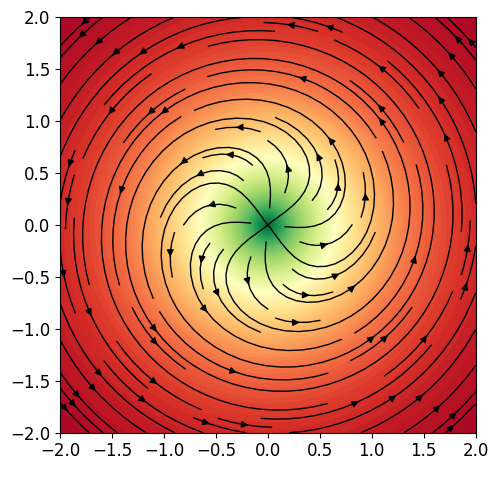

In [9]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.set_aspect("equal")
ax.set_xlim(-SPACE_SIZE, SPACE_SIZE)
ax.set_ylim(-SPACE_SIZE, SPACE_SIZE)
ax.set_xlabel("Ag")  # vphantom
ax.xaxis.label.set_alpha(0.0)

a = np.linspace(-SPACE_SIZE, SPACE_SIZE, 101)
x, y = np.meshgrid(a, a)
u, v = wind_fn(x, y)
r = reward_fn(x, y)

ax.contourf(x, y, r, levels=100, cmap="RdYlGn")
ax.streamplot(x, y, u, v, density=1, color="k", linewidth=1)

fig.tight_layout()
fig.savefig(fig_path / "wind_env.pdf")

## gymnax Environment

In [10]:
from gymnax.environments import spaces
from gymnax.environments.environment import Environment, EnvParams

In [11]:
class WindEnv(Environment):
    def __init__(
        self,
        space_size: float,
        action_scale: float,
        wind_fn: Callable,
        reward_fn: Callable,
    ):
        super().__init__()
        self.space_size = space_size
        self.action_scale = action_scale
        self.max_action = 1.0

        self.wind_fn = wind_fn
        self.reward_fn = reward_fn

    def state_space(self, params: Optional[EnvParams] = None) -> spaces.Box:
        return spaces.Dict(
            {
                "pos": spaces.Box(-jnp.finfo(jnp.float32).max, jnp.finfo(jnp.float32).max, (2), jnp.float32),
                "last_pos": spaces.Box(-jnp.finfo(jnp.float32).max, jnp.finfo(jnp.float32).max, (2), jnp.float32),
                "time": spaces.Discrete(params.max_steps_in_episode),
            }
        )

    def action_space(self, params: Optional[EnvParams] = None) -> spaces.Box:
        return spaces.Box(low=-self.max_action, high=self.max_action, shape=(2,), dtype=jnp.float32)

    def observation_space(self, params: EnvParams) -> spaces.Box:
        high = jnp.array([self.space_size], dtype=jnp.float32)
        return spaces.Box(-high, high, shape=(2,), dtype=jnp.float32)

    def is_terminal(self, state: EnvState, params: EnvParams) -> bool:
        done = state.time >= params.max_steps_in_episode
        return done

    def get_obs(self, state: EnvState) -> chex.Array:
        return jnp.array(state.pos)

    def step_env(
        self,
        key: chex.PRNGKey,
        state: EnvState,
        action: float,
        params: EnvParams,
    ) -> tuple[chex.Array, EnvState, float, bool, dict]:
        # Regularize action
        action = self.action_scale * jnp.clip(action, -self.max_action, self.max_action)

        # Compute reward
        reward = self.reward_fn(*state.pos)

        # Compute new position
        wind = jnp.stack(self.wind_fn(*state.pos))
        new_pos = state.pos + action + wind
        new_pos = jnp.clip(new_pos, -self.space_size, self.space_size)
        state = EnvState(new_pos, state.pos, state.time + 1)

        done = self.is_terminal(state, params)

        return (
            jax.lax.stop_gradient(self.get_obs(state)),
            jax.lax.stop_gradient(state),
            jax.lax.stop_gradient(reward),
            jax.lax.stop_gradient(done),
            {},
        )

    def reset_env(self, key: chex.PRNGKey, params: EnvParams) -> tuple[chex.Array, EnvState]:
        pos = jnp.array([0.8, 0.0])  # Fixed initial position
        state = EnvState(pos=pos, last_pos=pos, time=0)

        return jax.lax.stop_gradient(self.get_obs(state)), jax.lax.stop_gradient(state)

## Actor-Critic

In [12]:
class Actor(nn.Module):
    dim_action: int
    init_log_scale: float
    min_log_scale: float

    @nn.compact
    def __call__(self, x):
        activation = nn.tanh
        x = nn.Dense(64, kernel_init=orthogonal(jnp.sqrt(2)), bias_init=constant(0.0))(x)
        x = activation(x)
        x = nn.Dense(64, kernel_init=orthogonal(jnp.sqrt(2)), bias_init=constant(0.0))(x)
        x = activation(x)
        x = nn.Dense(self.dim_action, kernel_init=orthogonal(0.01), bias_init=constant(0.0))(x)
        log_scale = self.param("log_scale", nn.initializers.constant(self.init_log_scale), ())
        log_scale = jnp.clip(log_scale, self.min_log_scale, 0.0)
        x = distrax.Normal(loc=x, scale=jnp.ones_like(x) * jnp.exp(log_scale))
        return x


class Critic(nn.Module):
    dim_statistic: int
    head: Optional[Callable] = None

    @nn.compact
    def __call__(self, x):
        activation = nn.tanh
        x = nn.Dense(64, kernel_init=orthogonal(jnp.sqrt(2)), bias_init=constant(0.0))(x)
        x = activation(x)
        x = nn.Dense(64, kernel_init=orthogonal(jnp.sqrt(2)), bias_init=constant(0.0))(x)
        x = activation(x)
        x = nn.Dense(self.dim_statistic, kernel_init=orthogonal(1.0), bias_init=constant(0.0))(x)
        if self.head is not None:
            x = self.head(x)
        return x

In [13]:
def sample_action(d_action: jnp.ndarray, key: chex.PRNGKey) -> tuple[jnp.ndarray, jnp.ndarray, chex.PRNGKey]:
    key, action_key = jax.random.split(key)
    action = d_action.sample(seed=action_key)
    log_prob = d_action.log_prob(action)
    return action, log_prob, key

## Trajectory

In [14]:
import functools as ft

In [15]:
def jax_step(
    env: Environment,
    env_params: EnvParams,
    actor: Actor,
    critic: Critic,
    post: Callable,
    agent_state: AgentState,
    runner_state_key: tuple[RunnerState, chex.PRNGKey],
):
    # Unpack
    actor_state, critic_state = agent_state
    runner_state, key = runner_state_key
    observation, env_state = runner_state

    # Sample action
    d_action = actor.apply(actor_state.params, observation)
    action, log_prob, key = sample_action(d_action, key)
    # Compute statistic and value
    statistic = critic.apply(critic_state.params, observation)
    value = post(statistic)

    # Step parallel environments
    key, step_key = jax.random.split(key)
    step_keys = jax.random.split(step_key, NUM_ENVS)
    next_observation, env_state, reward, done, info = jax.vmap(
        env.step,
        in_axes=(0, 0, 0, None),
    )(step_keys, env_state, action, env_params)

    # Pack
    runner_state = RunnerState(next_observation, env_state)
    step = Step(observation, action, log_prob, done, reward, statistic, value, info)
    return (runner_state, key), step


def jax_trajectory(
    env: Environment,
    env_params: EnvParams,
    actor: Actor,
    critic: Critic,
    post: Callable,
    agent_state: AgentState,
    runner_state: RunnerState,
    key: chex.PRNGKey,
) -> tuple[Step, RunnerState, chex.PRNGKey]:
    (runner_state, key), trajectory = forward(
        f=ft.partial(jax_step, env, env_params, actor, critic, post, agent_state),
        init=(runner_state, key),
        length=NUM_STEPS,
    )
    return trajectory, runner_state, key


In [16]:
def update_statistic_with_termination(
    init: jnp.ndarray,
    update: Callable,
    reward_done: tuple[jnp.ndarray, jnp.ndarray],
    statistic: jnp.ndarray,
):
    # Unpack
    reward, done = reward_done
    # If done, reset statistic to init, otherwise update statistic
    return update(reward, jnp.where(done[:, None], init, statistic))


def get_advantage(
    last_statistic: jnp.ndarray,
    trajectory: jnp.ndarray,
    init: jnp.ndarray,
    update: Callable,
    post: Callable,
):
    statistic = scanr(
        f=ft.partial(update_statistic_with_termination, init, update),
        init=last_statistic,
        xs=(trajectory.reward, trajectory.done),
    )
    advantage = post(statistic) - trajectory.value
    return advantage

## Loss functions

In [17]:
def actor_loss_fn(log_prob_pred, log_prob, advantage):
    ratio = jnp.exp(jnp.sum(log_prob_pred - log_prob, axis=-1))
    ratio_clipped = jnp.clip(ratio, 1.0 - CLIP_EPS, 1.0 + CLIP_EPS)
    advantages = (advantage - advantage.mean()) / (advantage.std() + 1e-8)
    actor_loss = -jnp.minimum(ratio, ratio_clipped) * advantages
    actor_loss = actor_loss.mean()
    return actor_loss


def value_loss_fn(value_pred, value, target):
    value_clipped = value + (value_pred - value).clip(-CLIP_EPS, CLIP_EPS)
    value_losses = jnp.square(value_pred - target)
    value_losses_clipped = jnp.square(value_clipped - target)
    value_loss = 0.5 * jnp.maximum(value_losses, value_losses_clipped).mean()
    return value_loss


def loss_fn(
    actor_params,
    critic_params,
    actor: Actor,
    critic: Critic,
    post: Callable,
    batch: Batch,
):
    # Unpack
    trajectory, advantage = batch

    # Compute action, log_prob, statistic, and value
    d_action = actor.apply(actor_params, trajectory.observation)
    log_prob = d_action.log_prob(trajectory.action)
    statistic = critic.apply(critic_params, trajectory.observation)
    value = post(statistic)

    # Compute actor loss, value loss, and entropy
    actor_loss = actor_loss_fn(log_prob, trajectory.log_prob, advantage)
    value_loss = value_loss_fn(value, trajectory.value, advantage + trajectory.value)
    entropy = d_action.entropy().mean()

    # Combine losses
    loss = actor_loss + VAL_COEF * value_loss - ENT_COEF * entropy

    return loss, LossInfo(loss=loss, actor_loss=actor_loss, value_loss=value_loss, entropy=entropy)

## Training

In [18]:
def prepare_minibatch(batch: Batch, key: chex.PRNGKey) -> tuple[Batch, chex.PRNGKey]:
    # Reshape batch
    batch = jax.tree_util.tree_map(lambda x: x.reshape((BATCH_SIZE,) + x.shape[2:]), batch)

    # Shuffle batch
    key, permutation_key = jax.random.split(key)
    permutation = jax.random.permutation(permutation_key, BATCH_SIZE)
    shuffled_batch = jax.tree_util.tree_map(lambda x: jnp.take(x, permutation, axis=0), batch)

    # Reshape to minibatches
    minibatches = jax.tree_util.tree_map(
        lambda x: jnp.reshape(x, [NUM_MINIBATCHES, -1] + list(x.shape[1:])),
        shuffled_batch,
    )

    return minibatches, key


def update_agent(
    actor: Actor,
    critic: Critic,
    post: Callable,
    agent_state: AgentState,
    minibatch: Batch,
) -> tuple[AgentState, LossInfo]:
    # Unpack
    actor_state, critic_state = agent_state

    # Calculate gradients wrt actor and critic parameters
    grad_fn = jax.grad(loss_fn, argnums=[0, 1], has_aux=True)
    (actor_grads, critic_grads), loss_info = grad_fn(
        actor_state.params, critic_state.params, actor, critic, post, minibatch
    )

    # Update actor and critic states
    actor_state = actor_state.apply_gradients(grads=actor_grads)
    critic_state = critic_state.apply_gradients(grads=critic_grads)

    # Pack
    agent_state = AgentState(actor_state, critic_state)

    return agent_state, loss_info


def update_step(
    actor: Actor,
    critic: Critic,
    init: jnp.ndarray,
    update: Callable,
    post: Callable,
    trajectory_fn: Callable,
    update_state_key: tuple[AgentState, RunnerState, chex.PRNGKey],
) -> tuple[tuple[RunnerState, AgentState, chex.PRNGKey], LossInfo]:
    agent_state, runner_state, key = update_state_key

    trajectory, runner_state, key = trajectory_fn(agent_state, runner_state, key)
    last_statistic = critic.apply(agent_state.critic_state.params, runner_state.observation)
    advantage = get_advantage(last_statistic, trajectory, init, update, post)
    batch = Batch(trajectory, advantage)
    minibatches, key = prepare_minibatch(batch, key)
    agent_state, loss_info = forward(
        f=lambda agent_state: jax.lax.scan(
            f=ft.partial(update_agent, actor, critic, post),
            init=agent_state,
            xs=minibatches,
        ),
        init=agent_state,
        length=NUM_UPDATE_EPOCHS,
    )
    return (agent_state, runner_state, key), loss_info

In [19]:
def linear_schedule(count):
    return LR * (1.0 - (count // (NUM_MINIBATCHES * NUM_UPDATE_EPOCHS)) / NUM_UPDATES)

In [20]:
def train(
    env: WindEnv,
    env_params: EnvParams,
    actor: Actor,
    critic: Critic,
    init: jnp.ndarray,
    update: Callable,
    post: Callable,
    seed: int = 42,
) -> AgentState:
    # Initialize random key
    key = jax.random.PRNGKey(seed)

    # Reset parallel environments
    key, reset_key = jax.random.split(key)
    reset_keys = jax.random.split(reset_key, NUM_ENVS)
    observation, env_state = jax.vmap(env.reset, in_axes=(0, None))(reset_keys, env_params)

    # Initialize runner state
    runner_state = RunnerState(observation, env_state)

    # Initialize agent state
    key, init_key = jax.random.split(key)
    actor_params = actor.init(init_key, observation)
    critic_params = critic.init(init_key, observation)
    tx = optax.chain(
        optax.clip_by_global_norm(MAX_GRAD_NORM),
        optax.adam(learning_rate=linear_schedule, eps=1e-5),
    )
    actor_state = TrainState.create(apply_fn=actor.apply, params=actor_params, tx=tx)
    critic_state = TrainState.create(apply_fn=critic.apply, params=critic_params, tx=tx)
    agent_state = AgentState(actor_state, critic_state)

    # Train agent
    trajectory_fn = ft.partial(jax_trajectory, env, env_params, actor, critic, post)
    (agent_state, runner_state, key), loss_info = forward(
        f=ft.partial(update_step, actor, critic, init, update, post, trajectory_fn),
        init=(agent_state, runner_state, key),
        length=NUM_UPDATES,
    )

    return agent_state, loss_info

In [21]:
def test(
    env: WindEnv,
    env_params: EnvParams,
    actor: Actor,
    actor_state: TrainState,
    num_steps: int,
    seed: int = 42,
):
    # Initialize random key
    key = jax.random.PRNGKey(seed)

    # Reset environment
    key, reset_key = jax.random.split(key)
    observation, env_state = env.reset(reset_key)

    # Run environment
    rewards = []
    observations = []
    for _ in range(num_steps):
        # Sample action
        key, act_key = jax.random.split(key)
        action = actor.apply(actor_state.params, observation).sample(seed=act_key)
        # Step environment
        key, step_key = jax.random.split(key)
        observation, env_state, reward, done, info = env.step(step_key, env_state, action, env_params)
        # Collect reward and observation
        rewards.append(reward)
        observations.append(observation)

    return jnp.array(rewards), jnp.stack(observations)

## Aggregation function


In [22]:
def post_none(statistic):
    return jnp.squeeze(statistic, axis=-1)

In [23]:
head_sum = None
init_sum = jnp.array([0.0])


def update_sum(discount: float = 1.0):
    def update(reward, sum):
        return reward[..., None] + discount * sum

    return update


post_sum = post_none

In [24]:
head_max = None
init_max = jnp.array([-jnp.inf])


def update_max(discount: float = 1.0):
    def update(reward, max):
        return jnp.maximum(reward[..., None], discount * max)

    return update


post_max = post_none

In [25]:
head_min = None
init_min = jnp.array([jnp.inf])


def update_min(discount: float = 1.0):
    def update(reward, min):
        return jnp.minimum(reward[..., None], discount * min)

    return update


post_min = post_none

In [26]:
def head_length_sum(output):
    length = jax.nn.softplus(output[..., 0])
    sum = output[..., 1]
    return jnp.stack([length, sum], axis=-1)


init_length_sum = jnp.array([0.0, 0.0])


def update_length_sum(reward, statistic):
    return statistic + jnp.stack([jnp.ones_like(reward), reward], axis=-1)


def post_mean(statistic):
    length = statistic[..., 0]
    sum = statistic[..., 1]
    return sum / length

In [27]:
def head_length_sum_square(output):
    length = jax.nn.softplus(output[..., 0])
    sum = output[..., 1]
    sum2 = jax.nn.softplus(output[..., 2])
    return jnp.stack([length, sum, sum2], axis=-1)


init_length_sum_square = jnp.array([0.0, 0.0, 0.0])


def update_length_sum_square(reward, statistic):
    return statistic + jnp.stack([jnp.ones_like(reward), reward, reward**2], axis=-1)


def post_mean_variance(lam: float = 1.0):
    def post(statistic):
        length, sum, sum2 = statistic[..., 0], statistic[..., 1], statistic[..., 2]
        mean = sum / length
        var = (sum2 / length - (mean) ** 2).clip(min=1e-8)
        return mean + lam * var

    return post

## Run

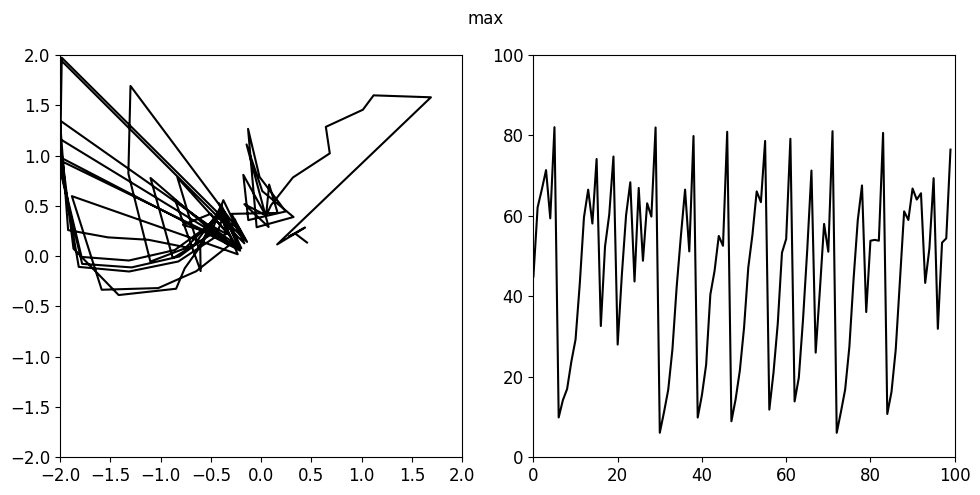

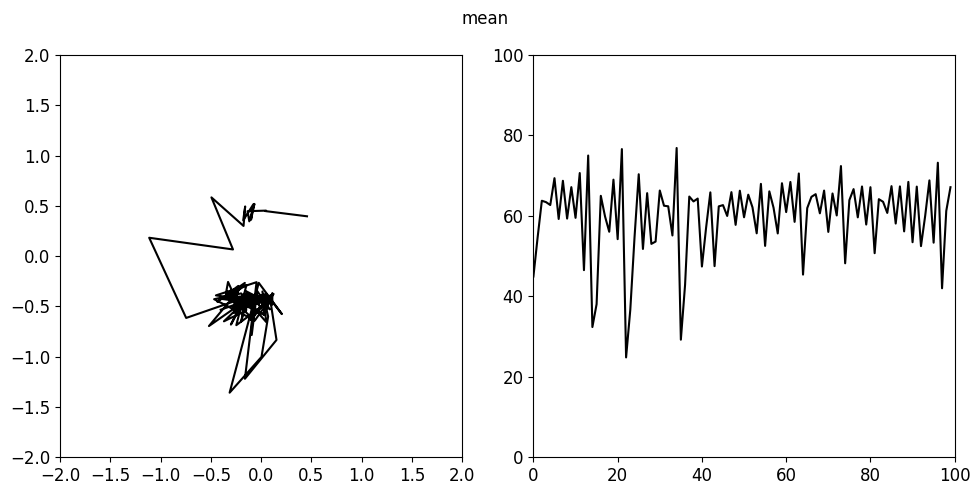

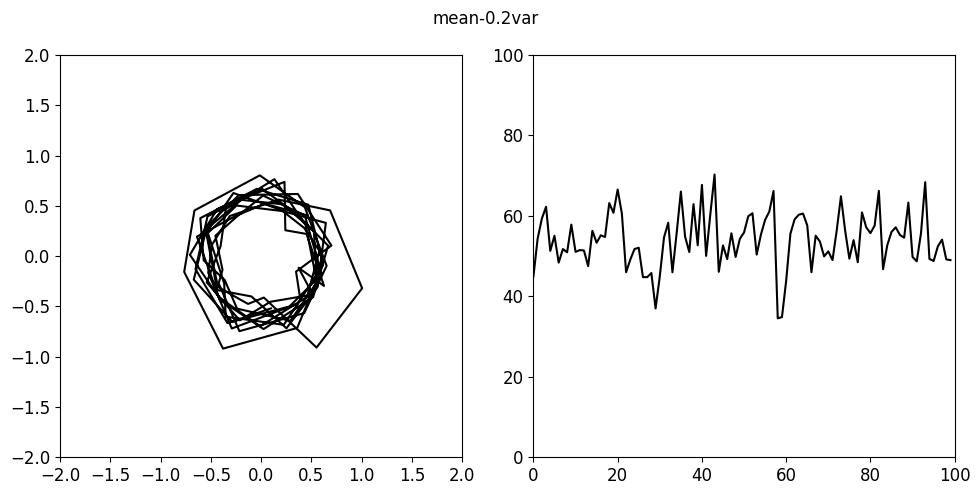

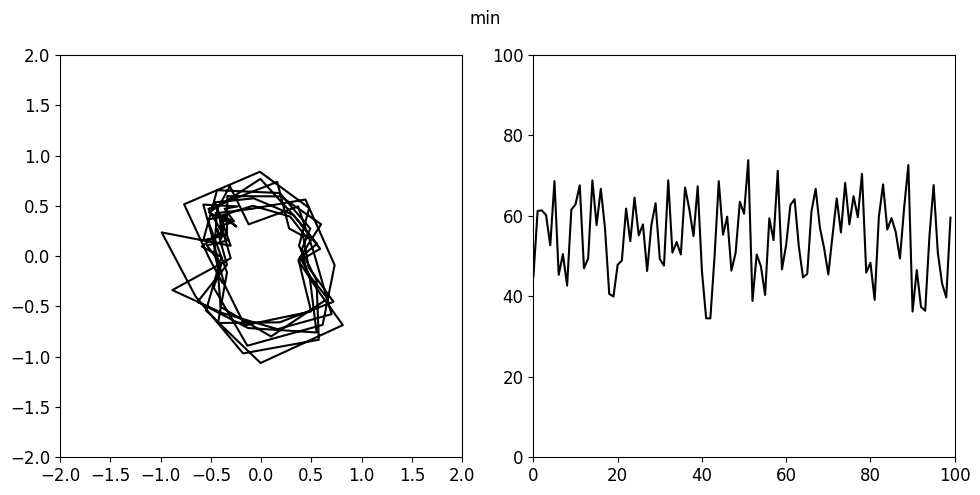

In [28]:
for name, head, init, update, post in [
    ("max", head_max, init_max, update_max(1.0), post_max),
    ("mean", head_length_sum, init_length_sum, update_length_sum, post_mean),
    ("mean-0.2var", head_length_sum_square, init_length_sum_square, update_length_sum_square, post_mean_variance(-0.2)),
    ("min", head_min, init_min, update_min(1.0), post_min),
]:
    dim_statistic = len(init)

    env = WindEnv(space_size=SPACE_SIZE, action_scale=ACTION_SCALE, wind_fn=wind_fn, reward_fn=reward_fn)
    env_params = EnvParams(max_steps_in_episode=128)

    actor = Actor(dim_action=DIM_ACTION, init_log_scale=INIT_LOG_SCALE, min_log_scale=MIN_LOG_SCALE)
    critic = Critic(dim_statistic=dim_statistic, head=head)

    agent_state, loss_info = train(env, env_params, actor, critic, init, update, post)
    rewards, observations = test(env, env_params, actor, agent_state.actor_state, 100)

    jnp.save(results_path / f"rewards_{name}.npy", rewards)
    jnp.save(results_path / f"positions_{name}.npy", observations)

    fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
    fig.suptitle(name)

    ax = axes[0]
    ax.set_aspect("equal")
    ax.set_xlim(-SPACE_SIZE, SPACE_SIZE)
    ax.set_ylim(-SPACE_SIZE, SPACE_SIZE)

    ax.plot(*observations.T, color="k")

    ax = axes[1]
    ax.set_xlim(0, len(rewards))
    ax.set_ylim(0, 100)

    ax.plot(rewards, color="k")

    fig.tight_layout()